In [15]:
#Import required libraries

import argparse
import gym
import numpy as np
from itertools import count
from collections import namedtuple
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [16]:
#Set constants for training
seed = 543
log_interval = 100
gamma = 0.99

env = gym.make('CartPole-v1')
env.reset()
torch.manual_seed(seed)
state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])


In [17]:

class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self,state_size,action_size):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(state_size, 128)

        # actor's layer
        self.action_head = nn.Linear(128, action_size)

        # critic's layer
        self.value_head = nn.Linear(128, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))

        # actor: choses action to take from state s_t
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t
        return action_prob, state_values


In [18]:
model = Policy(state_shape,no_of_actions)
optimizer = optim.Adam(model.parameters(), lr=3e-2)
eps = np.finfo(np.float32).eps.item()

In [19]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)
    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)
    # and sample an action using the distribution
    action = m.sample()
    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    # the action to take (left or right)
    return action.item()


def finish_episode():
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    #value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values
    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    for (log_prob, value), R in zip(saved_actions, returns):
        #advantage = R - value.item()
        advantage = R 
        # calculate actor (policy) loss
        policy_losses.append(-log_prob * advantage)
        # calculate critic (value) loss using L1 smooth loss
        #value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))
    # reset gradients
    optimizer.zero_grad()
    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum()
    # perform backprop
    loss.backward()
    optimizer.step()
    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]

def train():
    running_reward = 10
    # run infinitely many episodes
    for i_episode in range(2000):
        # reset environment and episode reward
        state = env.reset()
        ep_reward = 0
        # for each episode, only run 9999 steps so that we don't
        # infinite loop while learning
        for t in range(1, 10000):
            # select action from policy
            action = select_action(state)
            # take the action
            state, reward, done, _ = env.step(action)
            model.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        finish_episode()
        # update cumulative reward
        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        
        if i_episode % log_interval == 0:
            print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, running_reward))
            avg_reward.append(running_reward)
            
        # check if we have "solved" the cart pole problem
        if running_reward > env.spec.reward_threshold:
            print("Solved! Running reward is now {} and "
                  "the last episode runs to {} time steps!".format(running_reward, t))
            break

Episode 0	Last reward: 21.00	Average reward: 10.55
Episode 100	Last reward: 9.00	Average reward: 9.08
Episode 200	Last reward: 9.00	Average reward: 9.43
Episode 300	Last reward: 9.00	Average reward: 9.40
Episode 400	Last reward: 9.00	Average reward: 9.32
Episode 500	Last reward: 9.00	Average reward: 9.14
Episode 600	Last reward: 9.00	Average reward: 9.31
Episode 700	Last reward: 10.00	Average reward: 9.45
Episode 800	Last reward: 9.00	Average reward: 9.34
Episode 900	Last reward: 10.00	Average reward: 9.54
Episode 1000	Last reward: 9.00	Average reward: 9.19
Episode 1100	Last reward: 9.00	Average reward: 9.30
Episode 1200	Last reward: 9.00	Average reward: 9.45
Episode 1300	Last reward: 10.00	Average reward: 9.52
Episode 1400	Last reward: 9.00	Average reward: 9.39
Episode 1500	Last reward: 9.00	Average reward: 9.27
Episode 1600	Last reward: 10.00	Average reward: 9.54
Episode 1700	Last reward: 10.00	Average reward: 9.25
Episode 1800	Last reward: 9.00	Average reward: 9.37
Episode 1900	Last

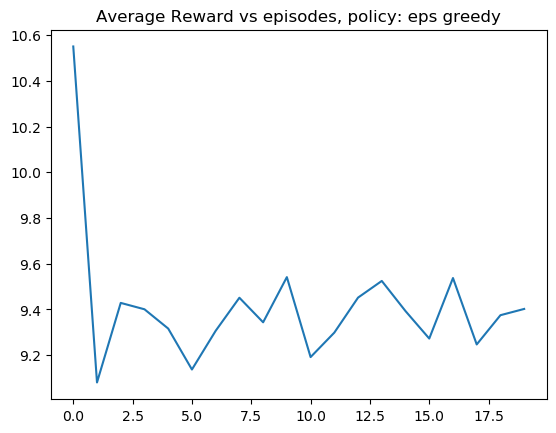

In [20]:
avg_reward =[]
train()
''' plt.plot( np.arange(0, len(avg_reward), 1), avg_reward)
plt.title("Average Reward vs episodes, policy: eps greedy")
plt.show() '''